In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

In [2]:
# gpt3 notes
nurse_gpt3_df = pd.read_excel('./excel_sheets/nurse_labelled_notes_gpt3.xlsx')
nurse_gpt3_df = nurse_gpt3_df.rename(columns={'report': 'nurse_reports', 'needs' : 'nurse_labels'})
gpt3_df = pd.read_excel('./excel_sheets/gpt3_labelled_notes.xlsx')
gpt3_df = gpt3_df.rename(columns={'report': 'gpt_reports', 'needs' : 'gpt_labels'})

# gpt4 notes
nurse_gpt4_df = pd.read_excel('./excel_sheets/nurse_labelled_notes_gpt4.xlsx')
nurse_gpt4_df = nurse_gpt4_df.rename(columns={'report': 'nurse_reports', 'needs' : 'nurse_labels'})
gpt4_df = pd.read_excel('./excel_sheets/gpt4_labelled_notes.xlsx')
gpt4_df = gpt4_df.rename(columns={'report': 'gpt_reports', 'needs' : 'gpt_labels'})

/Users/isabel/anaconda3/envs/nlp_metrics/lib/python3.12/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)
/Users/isabel/anaconda3/envs/nlp_metrics/lib/python3.12/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


In [3]:
def notes_cleaning(nurse_df, gpt_df, remove_comment_notes = False):
    # put all labels together
    compare_df = pd.concat([gpt_df, nurse_df], axis=1)
    # step 1 - find number of 'problematic notes' i.e., notes that were not deemed to be classifiable 
    mask = compare_df[['comments']].isnull().any(axis=1)
    comment_df = compare_df.dropna(subset=['comments'])
    print(f"\n---------\nPercentage of problematic notes ~{round((len(comment_df) / len(compare_df)) * 100, 2)}%")

    # step 2 - clean full dataframe to remove any unwanted information
    if remove_comment_notes:
        compare_df = compare_df[mask]
    cleaned_df = compare_df.drop(columns=['nurse_reports', 'comments'])

    # step 3 - remove any nan values
    mask = cleaned_df.isnull().any(axis=1)
    print(f"\n---------\nRows Removed Due to NaN Labels:\n{cleaned_df[mask]}\n---------\n")
    cleaned_df = cleaned_df.dropna()

    return cleaned_df

In [4]:
def calculate_statistics(df, title, filename):
    # accuracy
    accuracy = accuracy_score(df['nurse_labels'], df['gpt_labels'])
    print(f"Accuracy: {accuracy}")
    # precision
    precision = precision_score(df['nurse_labels'], df['gpt_labels'], pos_label='unmet')
    print(f"Precision: {precision}")
    # recall
    recall = recall_score(df['nurse_labels'], df['gpt_labels'], pos_label='unmet')
    print(f"Recall: {recall}")
    # f1 score
    f1 = f1_score(df['nurse_labels'], df['gpt_labels'], pos_label='unmet')
    print(f"F1 Score: {f1}")
    # cohen's kappa
    # we use https://www.jstor.org/stable/2529310?seq=4 to determine classifications
    cohen_k = cohen_kappa_score(df['nurse_labels'], df['gpt_labels'])
    if cohen_k < 0.00:
        print(f"Cohen's Kappa Score: {cohen_k}\nAgreement Level: Poor")
    elif cohen_k <= 0.2:
        print(f"Cohen's Kappa Score: {cohen_k}\nAgreement Level: Slight")
    elif cohen_k <= 0.4:
        print(f"Cohen's Kappa Score: {cohen_k}\nAgreement Level: Fair")
    elif cohen_k <= 0.6:
        print(f"Cohen's Kappa Score: {cohen_k}\nAgreement Level: Moderate")
    elif cohen_k <= 0.8:
        print(f"Cohen's Kappa Score: {cohen_k}\nAgreement Level: Substantial")
    elif cohen_k <= 1.0:
        print(f"Cohen's Kappa Score: {cohen_k}\nAgreement Level: Almost Perfect")
    else:
        print(f"Cohen's Kappa Score: {cohen_k}\nSomething Went Wrong!")
    
    # percentages correct and incorrect
    true_all = df[df['nurse_labels'] == df['gpt_labels']].shape[0]
    false_all = df[df['nurse_labels'] != df['gpt_labels']].shape[0]
    print(f"\n---------\nPercentage of correct notes ~{round((true_all / len(df)) * 100, 2)}%\nPercentage of incorrect notes ~{round((false_all / len(df)) * 100, 2)}%\n---------\n")


    # confusion matrix
    conf_matrix = confusion_matrix(df['nurse_labels'], df['gpt_labels'])
    ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['met', 'unmet']).plot()
    plt.xlabel('GPT Labels')
    plt.ylabel('Nurse Labels')
    plt.title(title)
    plt.savefig(f"./graphs/{filename}.png")
    plt.show()

# GPT3


---------
Percentage of problematic notes ~6.67%

---------
Rows Removed Due to NaN Labels:
Empty DataFrame
Columns: [gpt_reports, gpt_labels, nurse_labels]
Index: []
---------

Accuracy: 0.7482142857142857
Precision: 0.9761904761904762
Recall: 0.6817102137767221
F1 Score: 0.8027972027972028
Cohen's Kappa Score: 0.4834218721377541
Agreement Level: Moderate

---------
Percentage of correct notes ~74.82%
Percentage of incorrect notes ~25.18%
---------



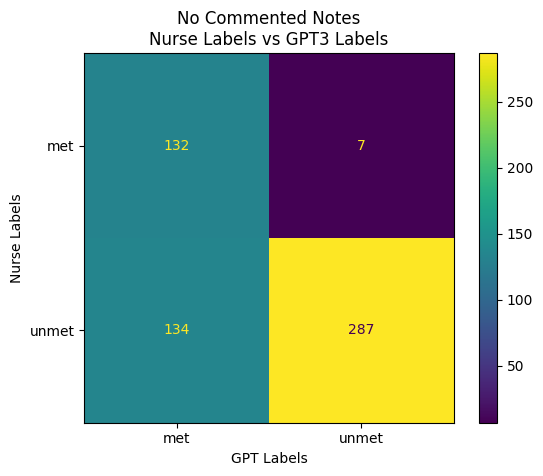

In [5]:
df = notes_cleaning(nurse_gpt3_df, gpt3_df, remove_comment_notes=True)
calculate_statistics(df, "No Commented Notes\nNurse Labels vs GPT3 Labels", "gpt3_no_commented_notes")


---------
Percentage of problematic notes ~6.67%

---------
Rows Removed Due to NaN Labels:
                                           gpt_reports gpt_labels nurse_labels
54   - Resident A had a peaceful night with no sign...        met          NaN
233  - Sarah experiencing increased difficulty with...      unmet          NaN
---------

Accuracy: 0.7090301003344481
Precision: 0.9728813559322034
Recall: 0.6335540838852097
F1 Score: 0.767379679144385
Cohen's Kappa Score: 0.42204250308275104
Agreement Level: Moderate

---------
Percentage of correct notes ~70.9%
Percentage of incorrect notes ~29.1%
---------



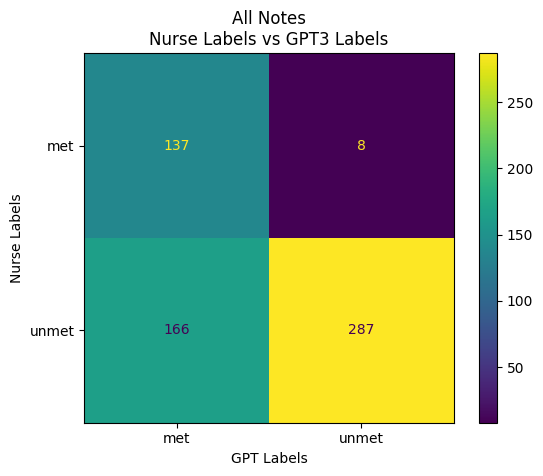

In [6]:
df = notes_cleaning(nurse_gpt3_df, gpt3_df, remove_comment_notes=False)
calculate_statistics(df, "All Notes\nNurse Labels vs GPT3 Labels", "gpt3_all_notes")

# GPT 4


---------
Percentage of problematic notes ~10.31%

---------
Rows Removed Due to NaN Labels:
Empty DataFrame
Columns: [gpt_reports, gpt_labels, nurse_labels]
Index: []
---------

Accuracy: 0.5214408233276158
Precision: 0.9016949152542373
Recall: 0.5155038759689923
F1 Score: 0.655980271270037
Cohen's Kappa Score: 0.033948435913121466
Agreement Level: Slight

---------
Percentage of correct notes ~52.14%
Percentage of incorrect notes ~47.86%
---------



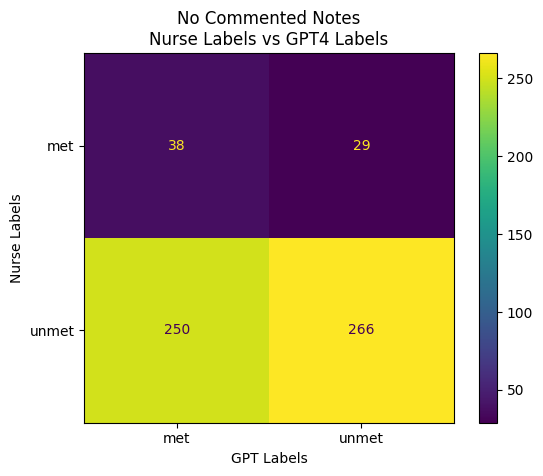

In [7]:
df = notes_cleaning(nurse_gpt4_df, gpt4_df, remove_comment_notes=True)
calculate_statistics(df, "No Commented Notes\nNurse Labels vs GPT4 Labels", "gpt4_no_commented_notes")


---------
Percentage of problematic notes ~10.31%

---------
Rows Removed Due to NaN Labels:
Empty DataFrame
Columns: [gpt_reports, gpt_labels, nurse_labels]
Index: []
---------

Accuracy: 0.5138461538461538
Precision: 0.8853503184713376
Recall: 0.4982078853046595
F1 Score: 0.6376146788990825
Cohen's Kappa Score: 0.0507265131068142
Agreement Level: Slight

---------
Percentage of correct notes ~51.38%
Percentage of incorrect notes ~48.62%
---------



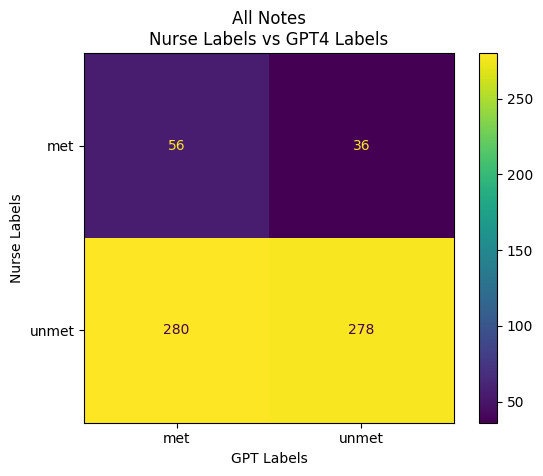

In [8]:
df = notes_cleaning(nurse_gpt4_df, gpt4_df, remove_comment_notes=False)
calculate_statistics(df, "All Notes\nNurse Labels vs GPT4 Labels", "gpt4_all_notes")